In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import (models, transforms)
import os
import utils
from pathlib import Path
import trainer
from torchinfo import summary
import time
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/p3rzival/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Preparation of the model

We will be using the original ViT in its smallest form (The ViT_B_16) to test the quantization results together with the Imaginette dataset

In [3]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
pretrained_vit_transforms = pretrained_vit_weights.transforms()

In [4]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=10).to(device)

In [5]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

We first will do fine-tunning to adecuate the model to the CIFAR10 dataset. Since we just want to test the efficency the quantization achieves and its tradeoff with accuracy, we will train the model for a small number of epochs, since what we want to see is how the accuracy is maintained ¡, and for that we do not need to fit the model perfectly to our data

In [6]:
train_dl, test_dl, val_dl, class_names = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=128)

Files already downloaded and verified


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pretrained_vit.parameters(), lr=0.03, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=10000)

In [8]:
pretrained_vit_results = trainer.train(model=pretrained_vit, train_dataloader=train_dl, 
                                       test_dataloader=test_dl, optimizer=optimizer, scheduler=scheduler,
                                       loss_fn=loss_fn, epochs=5, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0: SGD lr 0.0300 -> 0.0300


 20%|██        | 1/5 [06:10<24:41, 370.30s/it]

Epoch: 1 | train_loss: 0.2386 | train_acc: 0.9245 | test_loss: 0.1649 | test_acc: 0.9462
Epoch 1: SGD lr 0.0300 -> 0.0300


 40%|████      | 2/5 [12:44<19:13, 384.52s/it]

Epoch: 2 | train_loss: 0.1426 | train_acc: 0.9524 | test_loss: 0.1551 | test_acc: 0.9490
Epoch 2: SGD lr 0.0300 -> 0.0300


 60%|██████    | 3/5 [19:10<12:50, 385.09s/it]

Epoch: 3 | train_loss: 0.1248 | train_acc: 0.9582 | test_loss: 0.1565 | test_acc: 0.9487
Epoch 3: SGD lr 0.0300 -> 0.0300


 80%|████████  | 4/5 [25:49<06:30, 390.69s/it]

Epoch: 4 | train_loss: 0.1140 | train_acc: 0.9614 | test_loss: 0.1505 | test_acc: 0.9502
Epoch 4: SGD lr 0.0300 -> 0.0300


100%|██████████| 5/5 [32:21<00:00, 388.21s/it]

Epoch: 5 | train_loss: 0.1078 | train_acc: 0.9631 | test_loss: 0.1515 | test_acc: 0.9496


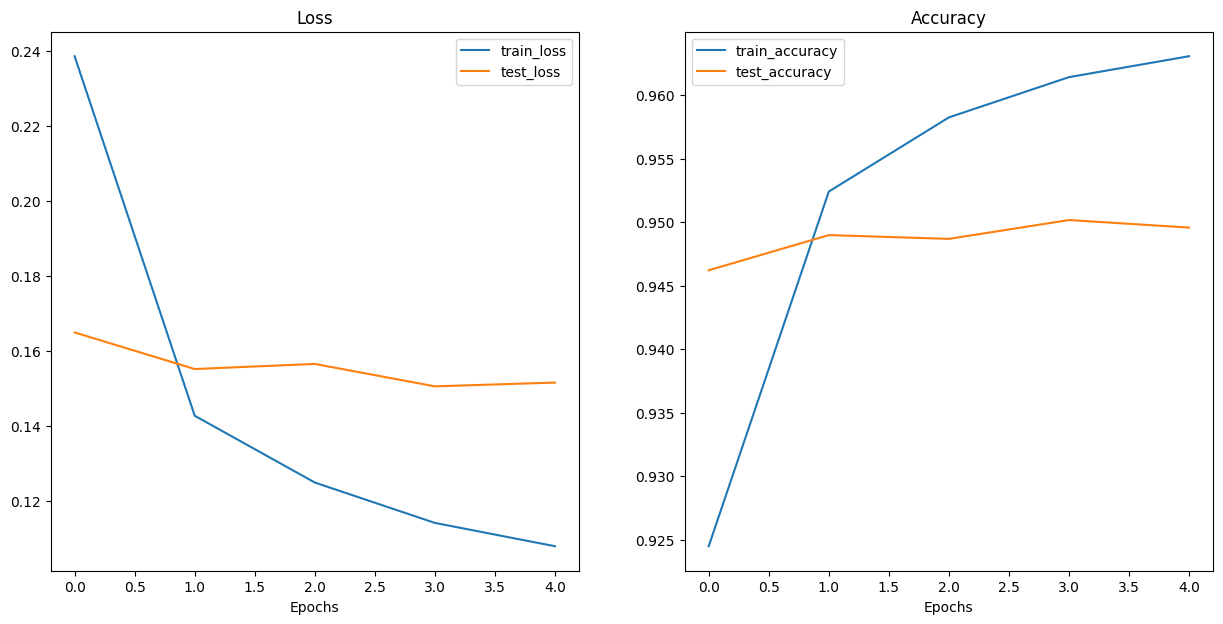

In [9]:
utils.plot_loss_curves(pretrained_vit_results)

After looking at the loss and accuracy curves it seems that our model could benefit from training some additional epochs, but since fitting the model to this particular data is not our goal right now, we will leave it like that

Let's save the model

In [10]:
target_dir_path = Path("model")
target_dir_path.mkdir(parents=True,
                    exist_ok=True)

# Create model save path
model_save_path = target_dir_path / "ViT-Default.pht"

# Save the model state_dict()
print(f"[INFO] Saving model to: {model_save_path}")
torch.save(obj=pretrained_vit.state_dict(),
        f=model_save_path)

[INFO] Saving model to: model/ViT-Default.pht


Now let's see how does it perform on the validation data, how much times does it take to give us the answer and how much does it weight

In [1]:
trainer.evaluate(pretrained_vit, val_dl, loss_fn, device)

NameError: name 'trainer' is not defined

/home/p3rzival/TFG-Efficient-Vision-Transformer-Inference-on-Edge-Devices/utils.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load(model_pa

Files already downloaded and verified


 18%|█▊        | 358/2000 [02:20<11:03,  2.48it/s]Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/usr/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-7uk40aqq'
100%|██████████| 2000/2000 [15:07<00:00,  2.20it/s]


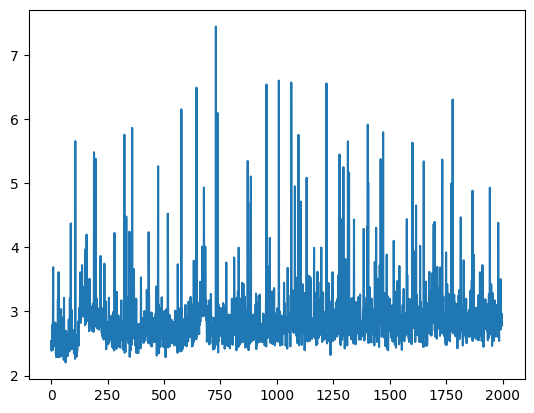

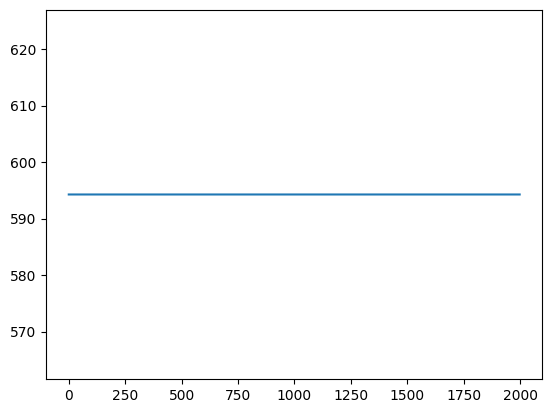

Mean time over 500 executions: 2.8873113705671805 ms/batch 
Mean memory over 500 executions: 594.26513671875 MB


In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = utils.load_default_model()
pretrained_vit_transforms = pretrained_vit_weights.transforms()
_, _, val_dl, _ = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=32)
metrics = trainer.getMetrics(pretrained_vit, val_dl, device, num_times=2000)

([<matplotlib.lines.Line2D at 0x78ce001accd0>],
 [<matplotlib.lines.Line2D at 0x78ce001059d0>])

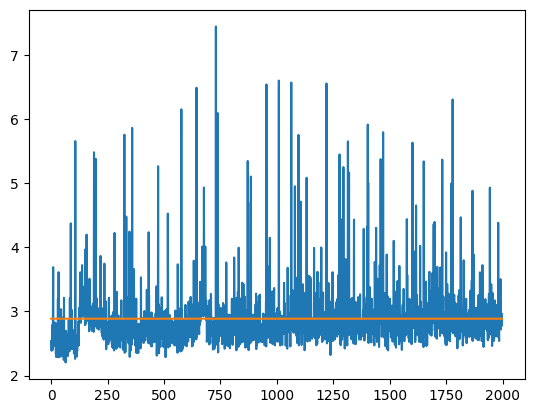

In [ ]:
mean = np.repeat(np.mean(metrics["Latency"][1:]), 2000)
plt.plot(metrics["Latency"][1:]),plt.plot(mean[1:])